# A simple GP 

Here we will put together a simple GP using the equations given in the lectures.  I have given all the equations you will need in the notes below.  You should note that this implementation of a GP is slow, $\mathcal{O}(n^{3})$.  For this reason we will avoid exploring the parameter space in an extensive and systematic way.  You should however, play around. Do your own exploration of the impact of the hyperparameters passed to the kernel.

Having said that this implementation is slow, you will see that it is substantially faster than the work we did in the kernal sandbox notebook.

Let's import the libraries we need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

And now implement your kernel function in the same way as in the kernel sandbox notebook.  For now start with a squared exponential kernel function but feel free to change this as you become more familiar.

$k(x_i, x_j) = \sigma^2 \exp \left(\frac{-1}{2 l^2} (x_i - x_j)^2 \right)$

If we set the mean function to be zero ($m({\bf t}) = 0$) then we now have enough information to completely define our Gaussian process.

I will now define some observed data.  The data has been collected at time $t_1$ and has been observed to be $y_1$ with very little (we will ignore it) uncertainty.  Below I make an array (actually a Python list) of data:

In [87]:
t_1= [1.0]
y_1 = [0.1]

## The Gaussian Process

If we start with the 'classic' GP probability equation:

$p({\bf y_1, y_2}) = \mathcal{N}\left( \begin{bmatrix} {\bf a} \\ {\bf c} \end{bmatrix},  \begin{bmatrix} A & B \\ B^{T} & C \end{bmatrix} \right)$

and I'll remind you of what $A, B, C$ really mean.

We have some observations $y_1$ taken at $t_1$ and there are some predictions we want to make of $y_2$ and times $t_2$.

$A$ is the covariance matrix that describes the covariance of the data.  That is the covariance of the points in $t_1$ with the other points in $t_1$, where $t_1$ has length $n$.

$A = \begin{bmatrix} {\rm var}(y_{1,0}) & {\rm cov}(y_{1,0}, y_{1,1}) & ... & {\rm cov}(y_{1,0}, y_{1,n}) \\ 
                     {\rm cov}(y_{1,1}, y_{1,0}) & {\rm var}(y_{1,1}) & ... & {\rm cov}(y_{1,1}, y_{1,n}) \\
                     ... & ... & ... & ... \\
                     {\rm cov}(y_{1,n}, y_{1,0}) & ... & ... & {\rm var}(y_{1,n}) \end{bmatrix}$
                     
$C$ is the covariance matrix that describes the covariance of the prediction.  That is the covariance of the points in $t_2$ with the other points in $t_2$, where $t_2$ has length $m$.

$C = \begin{bmatrix} {\rm var}(y_{2,0}) & {\rm cov}(y_{2,0}, y_{2,1}) & ... & {\rm cov}(y_{2,0}, y_{2,m}) \\ 
                     {\rm cov}(y_{2,1}, y_{2,0}) & {\rm var}(y_{2,1}) & ... & {\rm cov}(y_{2,1}, y_{2,m}) \\
                     ... & ... & ... & ... \\
                     {\rm cov}(y_{2,m}, y_{2,0}) & ... & ... & {\rm var}(y_{2,m}) \end{bmatrix}$

$B$ is the covariance matrix that describes the covariance of the prediction and the data.  That is the covariance of the points in $t_1$ with the points in $t_2$.

$B = \begin{bmatrix} {\rm cov}(y_{1,0}, y_{2,0}) & {\rm cov}(y_{1,0}, y_{2,1}) & ... & {\rm cov}(y_{1,0}, y_{2,n}) \\ 
                     {\rm cov}(y_{1,1}, y_{2,0}) & {\rm cov}(y_{1,1}, , y_{2,1}) & ... & {\rm cov}(y_{1,1}, y_{2,n}) \\
                     ... & ... & ... & ... \\
                     {\rm cov}(y_{1,m}, y_{2,0}) & ... & ... & {\rm cov}(y_{1,m}, y_{2,n}) \end{bmatrix}$

Using the python function we have writen, we can easily calculate $A, B, C$.  We denote the hyperparameters passed to the kernel function as $\theta$.

$A = K(t_1, t_1, \theta)$

$C = K(t_2, t_2, \theta)$

$B = K(t_1, t_2, \theta)$

## The likelihood function

We defined the multivariate normal probability distribution in the lectures:

$p({\bf y}) = \operatorname{det}(2\pi \Sigma)^{-\frac{1}{2}} \, \exp \left( { -\frac{1}{2}(\mathbf{y - \mu}) \Sigma^{-1}(\mathbf{y - \mu})^{T} } \right)$,

and can use the more compact notation in the context of a $\mathcal{GP}$:

$p({\bf y_1, y_2}) = \mathcal{N}\left( \begin{bmatrix} {\bf a} \\ {\bf c} \end{bmatrix},  \begin{bmatrix} A & B \\ B^{T} & C \end{bmatrix} \right)$,

or 

$\begin{bmatrix} {\bf y_1} \\ {\bf y_2} \end{bmatrix} \sim \mathcal{N}\left( \begin{bmatrix} {\bf a} \\ {\bf c} \end{bmatrix},  \begin{bmatrix} A & B \\ B^{T} & C \end{bmatrix} \right)$.

When we have some data $y_1$ we recall that the likelihood function is:

$p({\bf y_1}) = \int p({\bf y_2}, {\bf y_1}) \,  {\rm d}{\bf y_2}$,

so 

$p({\bf y_1}) = \mathcal{N}({\bf a}, A)$.

Which is even more straight forward when we set the mean function to be zero:

$p({\bf y_1}) = \mathcal{N}({\bf 0}, A)$.

And expanding this out so you have if for reference we have:

$p({\bf y_1}) = \operatorname{det}(2\pi A)^{-\frac{1}{2}} \, \exp \left( { -\frac{1}{2}\mathbf{y_1} A^{-1}\mathbf{y_1} } \right)$,

or

$\log p({\bf y_1}) = -\frac{1}{2} {\bf y_1}^{T} A^{-1} {\bf y_1} - \frac{1}{2} \log|A| - \frac{n}{2} \log 2\pi$.

Write a function that accepts as arguments the data $\bf y_1$ and the covariance matric $A$ and returns $p({\bf y_1})$. (or returns $\log p({\bf y_1})$ )

## Making predictions

Making predictions using a GP is simply a case of using the conditional distribution:

$p({\bf y_2} | {\bf y_1}) = \frac{p({\bf y_1, y_2})}{p({\bf y_1})}$,

where

$p({\bf y_1, y_2}) = \mathcal{N}\left( \begin{bmatrix} {\bf a} \\ {\bf c} \end{bmatrix},  \begin{bmatrix} A & B \\ B^{T} & C \end{bmatrix} \right)$,

and 

$p({\bf y_1}) = \mathcal{N}({\bf a}, A)$.

If we include non-zero mean terms then this becomes:

$p({\bf y_2} | {\bf y_1}) = \mathcal{N}({\bf c} + BA^{-1} ({\bf y_1} - {\bf a}), C - BA^{-1}B^{T})$.

Or the mean terms set to zero this becomes:

$p({\bf y_2} | {\bf y_1}) = \mathcal{N}(BA^{-1} ({\bf y_1}), C - BA^{-1}B^{T})$.

Write a function that accepts as arguments: $\bf t_2$; $\bf t_1$; the kernel function; the kernel parameters $\theta$; and the observed data points $\bf y_1$.  This function should return the predicted mean values and the predicted variance for the points in $\bf t_2$.

The function will take the following form ...

In [83]:
def predict(t_2, t_1, kernel, theta, y_1):
    B = kernel(t_1, t_2, theta)
    #YOUR CODE HERE
    #MORE OF YOUR CODE
    #...
    #MORE OF YOUR CODE
    y_pred = 1 # Delete this!
    sigma_new = 1 # Delete this!
    return y_pred, sigma_new

We can now run your code to make predictions at time $\bf t_2$.  Run the following code below:

(If something goes wrong try to find the reason using the returned error message.  If you are stuck ask for help!)

In [117]:
t_1= [1.0]
y_1 = [0.1]
t_2 = np.linspace(0, 2, 200)
theta = [1.0, 0.1]
predictions = [predict(i, t_1, kernel, theta, y_1) for i in t_2]
y_pred, sigmas = np.transpose(predictions)

We can now plot the results.  The code below is an example of a way to plot the predictions together with the observations.

Text(0,0.5,'y')

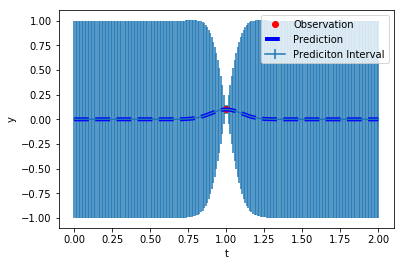

In [118]:
fig, ax = plt.subplots()
ax.errorbar(t_2, y_pred, yerr=sigmas**0.5, capsize=0, label='Prediciton Interval')
ax.plot(t_1, y_1, 'ro', label='Observation')
ax.plot(t_2, y_pred, 'b--', lw=4, label='Prediction')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('y')

Now let's add more data.  Run the code below and then write your own code to plot the results.

In [121]:
t_1= [1.0]
y_1 = [0.1]
t_1.append(1.3)
y_1.append(0.3)

predictions = [predict(i, t_1, kernel, theta, y_1) for i in t_2]
y_pred, sigmas = np.transpose(predictions)

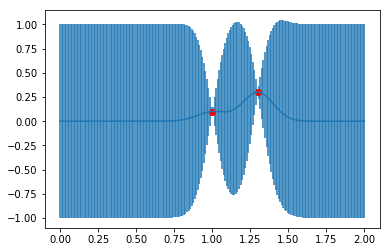

Now let's again add more data.  Run the code below and then write your own code to plot the results.  The impact of the observations should be obvious.  If you are are happy with what is going on, start to vary the properties of the kernel (the hyperparameters).  If you are really happy, see what happens when the data are generated using hyperparameters that are different to the hyperparameters used for the prediction.

If you explored different kernels in the snadbox notebook, then consider implemeting these kernels here.

Once you are comfortable move on to the last step.

In [133]:
t_1 = [0.4, 0.7, 1.1, 2.3, 2.9, 3.0]
theta = [1.0, 0.3]
y_1 = np.random.multivariate_normal(np.zeros(len(t_1)), kernel(t_1, t_1, theta))
t_2 = np.linspace(0, 4, 1000)
predictions = [predict(i, t_1, kernel, theta, y_1) for i in t_2]
y_pred, sigmas = np.transpose(predictions)

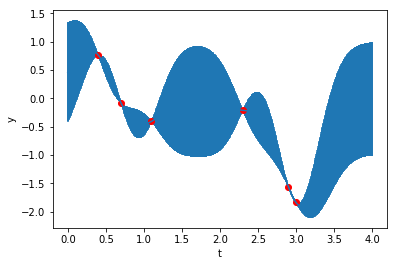

### The last step

As a last step in this notebook I would like you to explore how we might choose (or estimate even) sensible hyperparameters.  

We will use a simple 2D grid search.  For each $l$ in 'ls' and each $\sigma$ in 'sigmas' calculate the likelihood (or log likelihood) using the function that you wrote above.  Store each result in 'L[i, j]' and then use the cell below to plot the results.  (note if you are using the log likelihood already you will not need to take the log again).

We will not explore extensively and discussion of the uncertainties are beyond the scope of this exercise.  But it is worth you considering what the plot of the likelihood as a function of the hyperparameters means.

In [135]:
t_1 = [0.4, 0.7, 1.1, 2.3, 2.9, 3.0]
theta = [1.0, 1.0]
y_1 = np.random.multivariate_normal(np.zeros(len(t_1)), kernel(t_1, t_1, theta))
nps = 300
ls = np.linspace(0.01,2,nps)
sigmas = np.linspace(0.1,5.0,nps)
L = np.zeros([nps, nps])

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


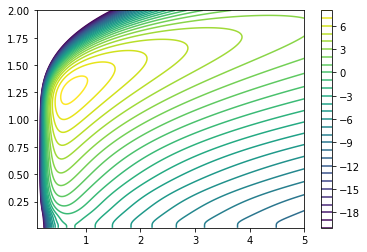

In [138]:
fig, ax = plt.subplots()
SIGMAS, LS = np.meshgrid(sigmas, ls)
levels = np.arange(- 20.0, L.max(), 1)
CS = ax.contour(SIGMAS, LS, np.log(L), levels=levels)
cbar = fig.colorbar(CS)

Now we move on to the last notebook.  In the final notebook we will use Celerite to take care of all of the lower level computations we have managed here.  